<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33600 entries, 0 to 33599
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     33600 non-null  object 
 1   Title                  33600 non-null  object 
 2   Movie Link             33600 non-null  object 
 3   Year                   33600 non-null  int64  
 4   Duration               33379 non-null  object 
 5   MPA                    25624 non-null  object 
 6   Rating                 33462 non-null  float64
 7   Votes                  33462 non-null  object 
 8   budget                 11815 non-null  float64
 9   grossWorldWide         18222 non-null  float64
 10  gross_US_Canada        17571 non-null  float64
 11  opening_weekend_Gross  15523 non-null  float64
 12  directors              33241 non-null  object 
 13  writers                32024 non-null  object 
 14  stars                  33127 non-null  object 
 15  ge

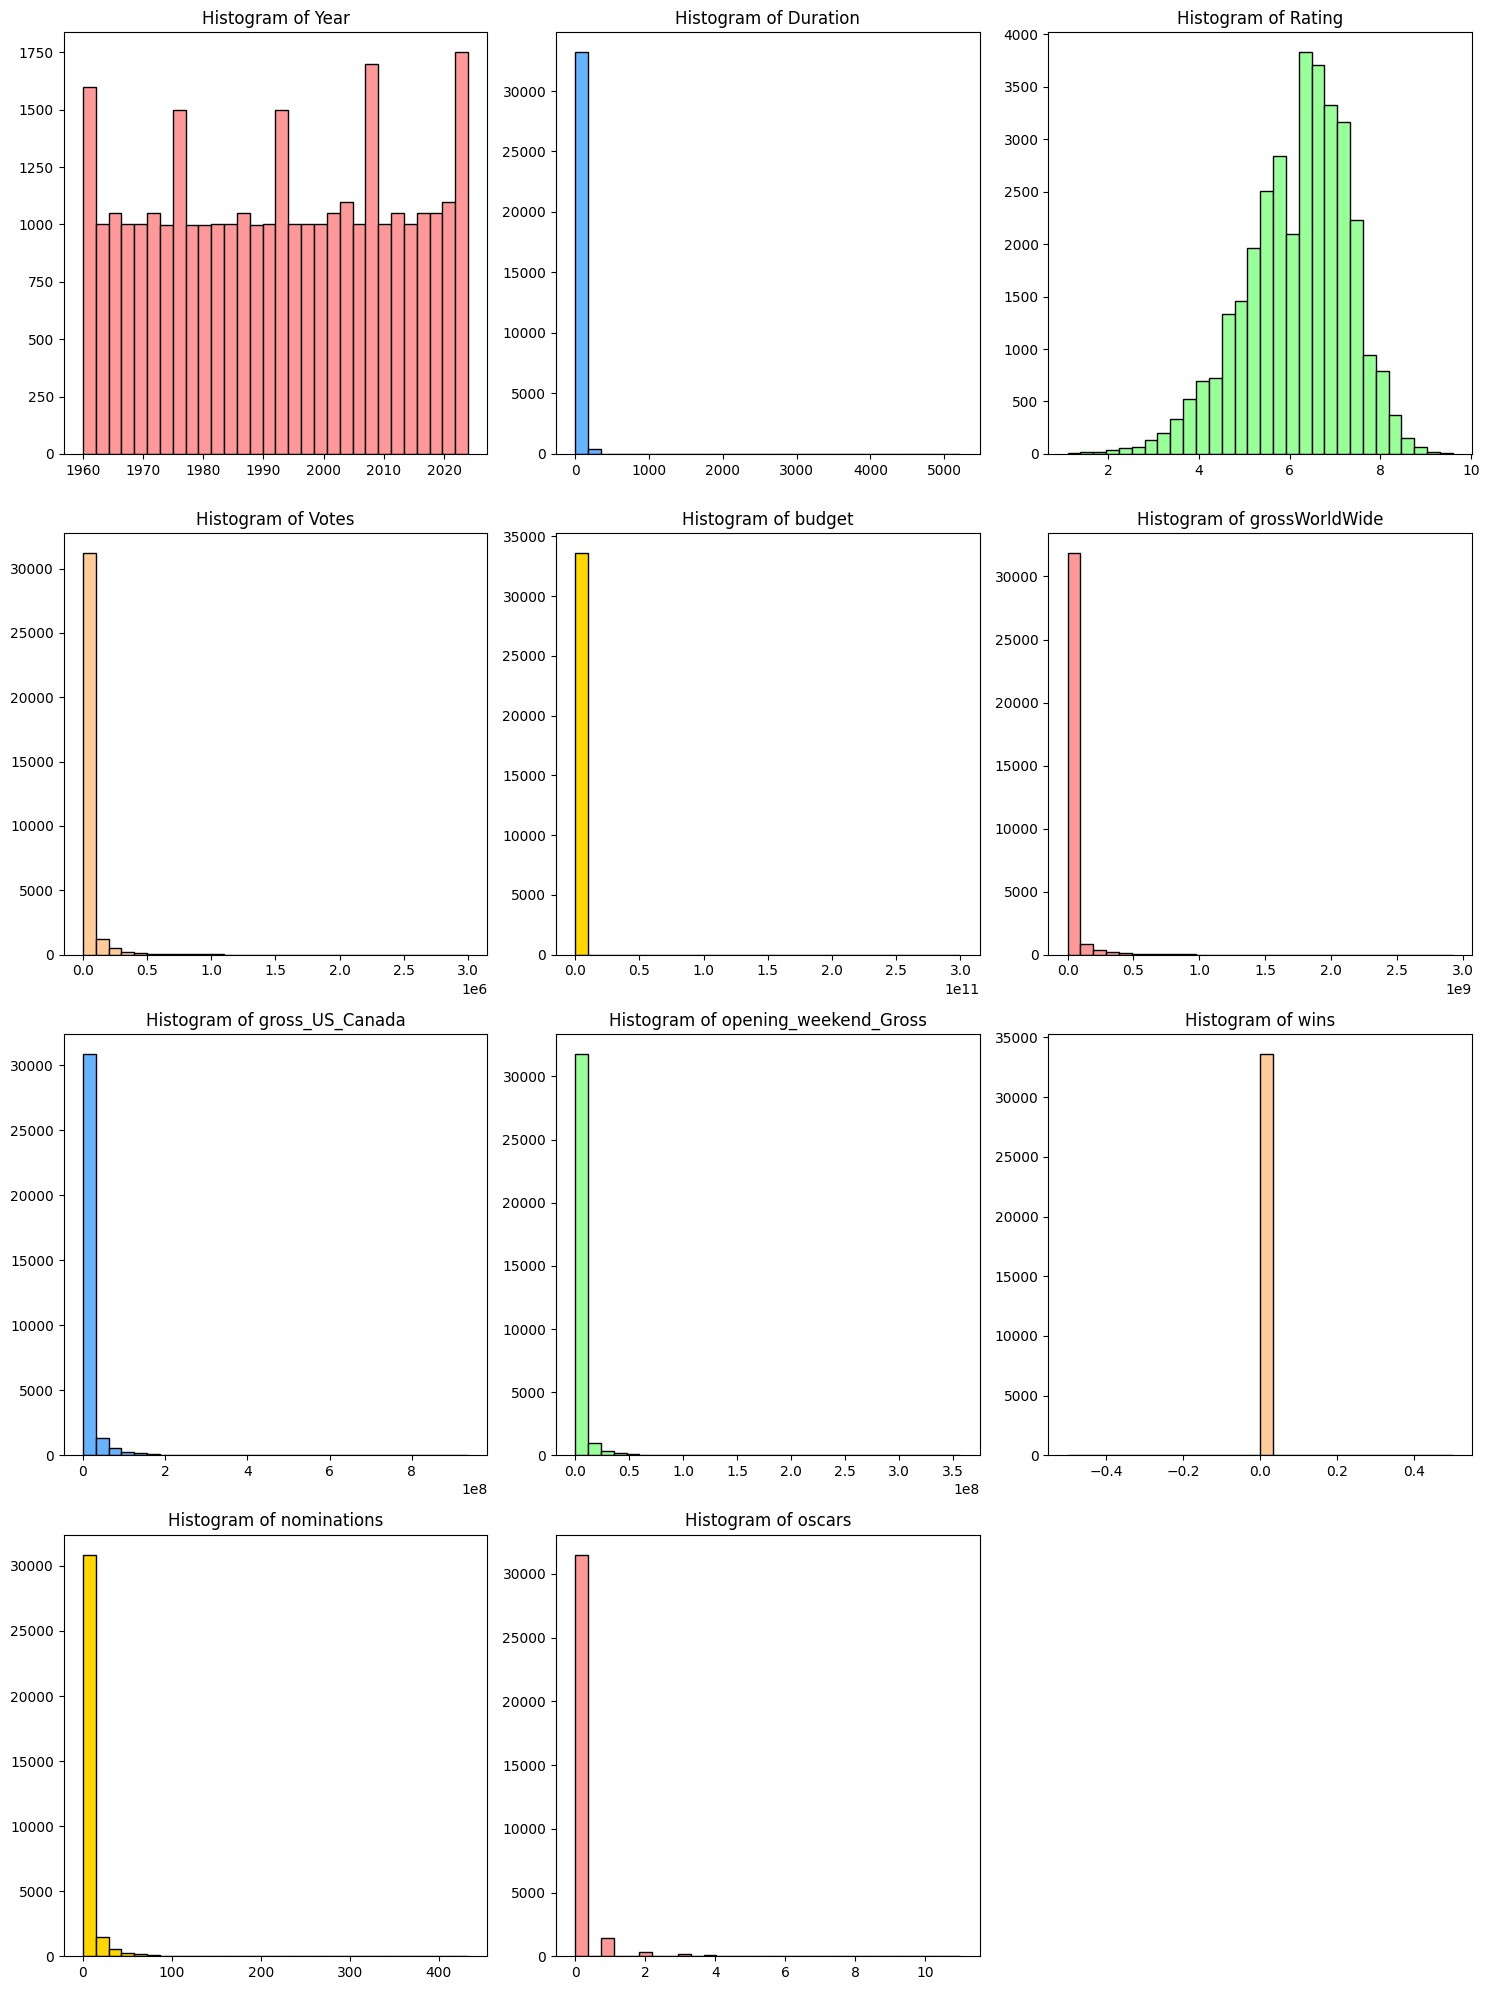

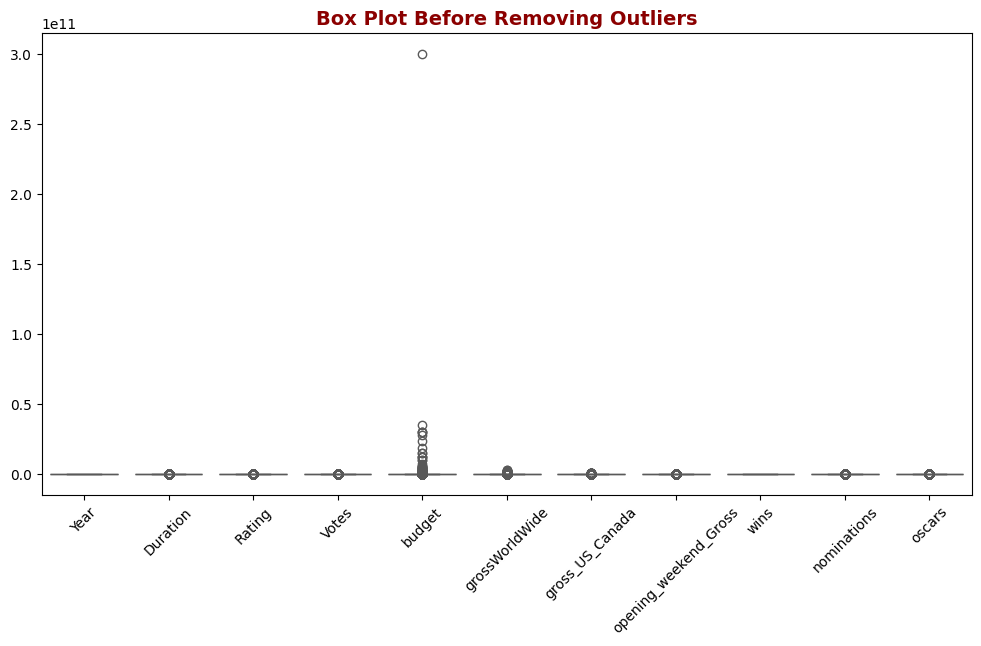

Iteration 1: Remaining samples = 11728
Iteration 2: Remaining samples = 8783


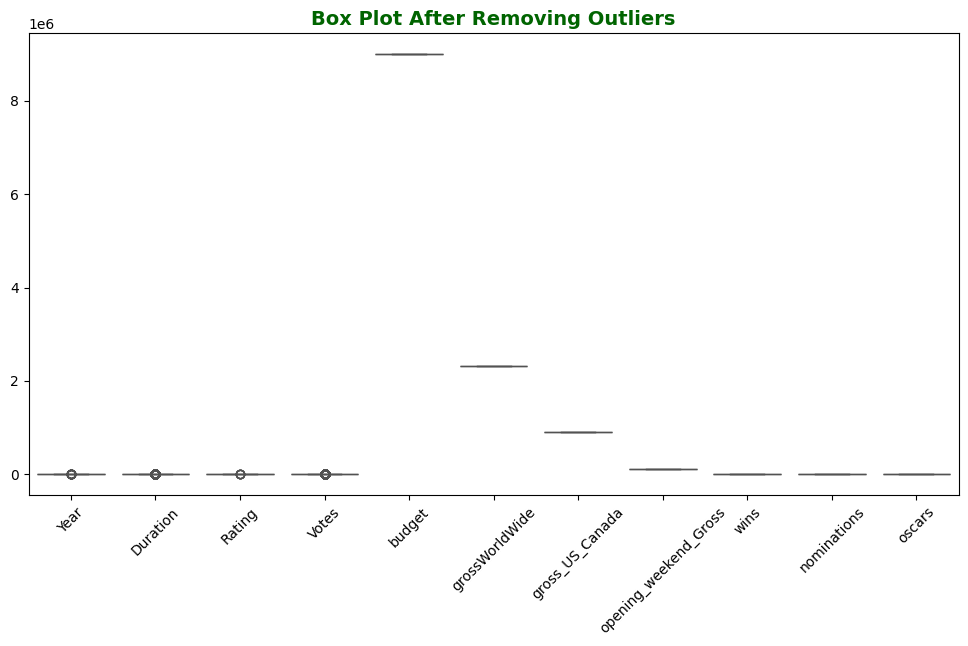

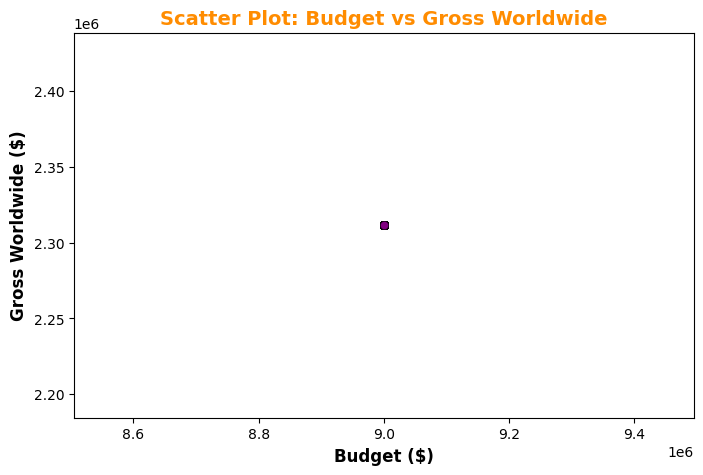


Skewness:
 Year                     0.504071
Duration                 0.178818
Rating                   0.038898
Votes                    1.633837
budget                   0.000000
grossWorldWide           0.000000
gross_US_Canada          0.000000
opening_weekend_Gross    0.000000
wins                     0.000000
nominations              0.000000
oscars                   0.000000
dtype: float64

Kurtosis:
 Year                    -0.528074
Duration                 0.275433
Rating                  -0.606864
Votes                    2.197393
budget                   0.000000
grossWorldWide           0.000000
gross_US_Canada          0.000000
opening_weekend_Gross    0.000000
wins                     0.000000
nominations              0.000000
oscars                   0.000000
dtype: float64

🔍 Model Evaluation Results:
Linear Regression - MAE: 0.79, R² Score: 0.18
Random Forest Regressor - MAE: 0.81, R² Score: 0.12
Support Vector Regressor - MAE: 0.76, R² Score: 0.22


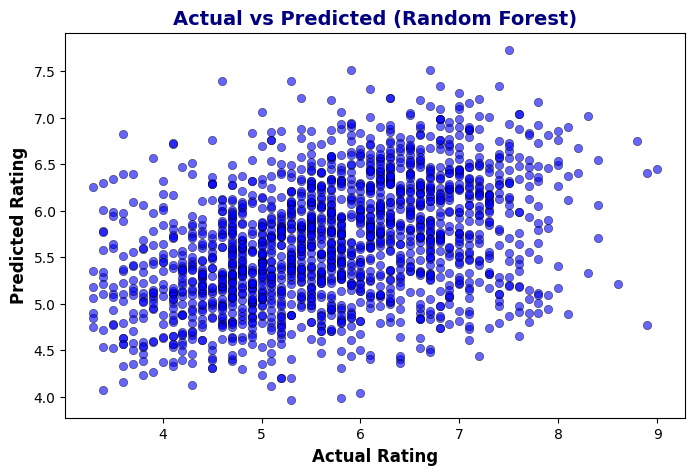

In [2]:
# 📌 Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import math

# 📌 Load the dataset
file_path = "/content/IMDB_final_dataset.csv"
df = pd.read_csv(file_path)

# 📌 Display dataset info
print("\nDataset Info:\n", df.info())
print("\nFirst 5 rows:\n", df.head())

# 📌 Drop unnecessary columns
drop_columns = ['id', 'Title', 'Movie Link', 'directors', 'writers', 'stars', 'genres',
                'countries_origin', 'filming_locations', 'production_companies', 'Languages']
df.drop(columns=drop_columns, inplace=True)

# 📌 Convert 'Votes' column to numeric (handle 'K' and 'M')
def convert_votes(votes):
    if isinstance(votes, str):
        if 'M' in votes:
            return float(votes.replace('M', '')) * 1_000_000
        elif 'K' in votes:
            return float(votes.replace('K', '')) * 1_000
    return votes

df['Votes'] = df['Votes'].apply(convert_votes).astype(float)

# 📌 Convert 'Duration' to minutes (from 'h m' format)
def convert_duration(duration):
    if isinstance(duration, str):
        parts = duration.split(' ')
        minutes = 0
        for part in parts:
            if 'h' in part:
                minutes += int(part.replace('h', '')) * 60
            elif 'm' in part:
                minutes += int(part.replace('m', ''))
        return minutes
    return duration

df['Duration'] = df['Duration'].apply(convert_duration).astype(float)

# 📌 Handle missing values (fill with median for numeric columns)
numeric_cols = df.select_dtypes(include=["number"]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.median()))

# 📊 **Step 1: Statistical Analysis**
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# 1️⃣ Histograms (Before Outlier Removal)
num_plots = len(numeric_columns)
rows = math.ceil(num_plots / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']
for idx, col in enumerate(numeric_columns):
    axes[idx].hist(df[col], bins=30, color=colors[idx % len(colors)], edgecolor="black")
    axes[idx].set_title(f"Histogram of {col}")

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])  # Hide unused subplots

plt.tight_layout()
plt.show()

# 2️⃣ Box Plot (Before Outlier Removal)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_columns], palette="Set2")
plt.xticks(rotation=45)
plt.title("Box Plot Before Removing Outliers", fontsize=14, fontweight="bold", color="darkred")
plt.show()

# 📌 Remove Outliers Twice Using IQR
df_cleaned = df.copy()  # Create a copy to avoid modifying the original dataset

for i in range(2):  # Remove outliers twice
    Q1 = df_cleaned[numeric_columns].quantile(0.25)
    Q3 = df_cleaned[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df_cleaned[~((df_cleaned[numeric_columns] < (Q1 - 1.5 * IQR)) |
                              (df_cleaned[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    print(f"Iteration {i+1}: Remaining samples = {len(df_cleaned)}")

# 3️⃣ Box Plot (After Outlier Removal)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned[numeric_columns], palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Box Plot After Removing Outliers", fontsize=14, fontweight="bold", color="darkgreen")
plt.show()

# 4️⃣ Scatter Plot (Budget vs Gross Worldwide)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_cleaned['budget'], y=df_cleaned['grossWorldWide'], color="purple", alpha=0.7, edgecolor="black")
plt.xlabel("Budget ($)", fontsize=12, fontweight="bold", color="black")
plt.ylabel("Gross Worldwide ($)", fontsize=12, fontweight="bold", color="black")
plt.title("Scatter Plot: Budget vs Gross Worldwide", fontsize=14, fontweight="bold", color="darkorange")
plt.show()

# 5️⃣ Skewness & Kurtosis
print("\nSkewness:\n", df_cleaned[numeric_columns].skew())
print("\nKurtosis:\n", df_cleaned[numeric_columns].kurtosis())

# 📈 **Step 2: Machine Learning**
# 📌 Define features (X) and target variable (y)
X = df_cleaned[['Year', 'Duration', 'Votes', 'budget', 'grossWorldWide', 'wins', 'nominations', 'oscars']]
y = df_cleaned['Rating']

# 📌 Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Standardize features for SVR (important for kernel-based methods)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 📌 Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# 📌 Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
svr_model.fit(X_train_scaled, y_train)  # SVR requires scaled data

# 📌 Make Predictions
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)

# 📌 Evaluation function
def evaluate_model(model_name, y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"{model_name} - MAE: {mae:.2f}, R² Score: {r2:.2f}")

# 📌 Evaluate all models
print("\n🔍 Model Evaluation Results:")
evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("Random Forest Regressor", y_test, rf_pred)
evaluate_model("Support Vector Regressor", y_test, svr_pred)

# 📌 Scatter plot of Actual vs Predicted (Random Forest example)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=rf_pred, color="blue", alpha=0.6, edgecolor="black")
plt.xlabel("Actual Rating", fontsize=12, fontweight="bold", color="black")
plt.ylabel("Predicted Rating", fontsize=12, fontweight="bold", color="black")
plt.title("Actual vs Predicted (Random Forest)", fontsize=14, fontweight="bold", color="navy")
plt.show()
